<a href="https://colab.research.google.com/github/KIRTIRAJ4327/30days-AI-challenge/blob/main/Day21_Video_Content_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Core Concept: Video Understanding**

Video understanding is a subfield of computer vision that focuses on analyzing and extracting meaningful information from video content. Unlike simple image analysis, video understanding deals with temporal information (how things change over time).

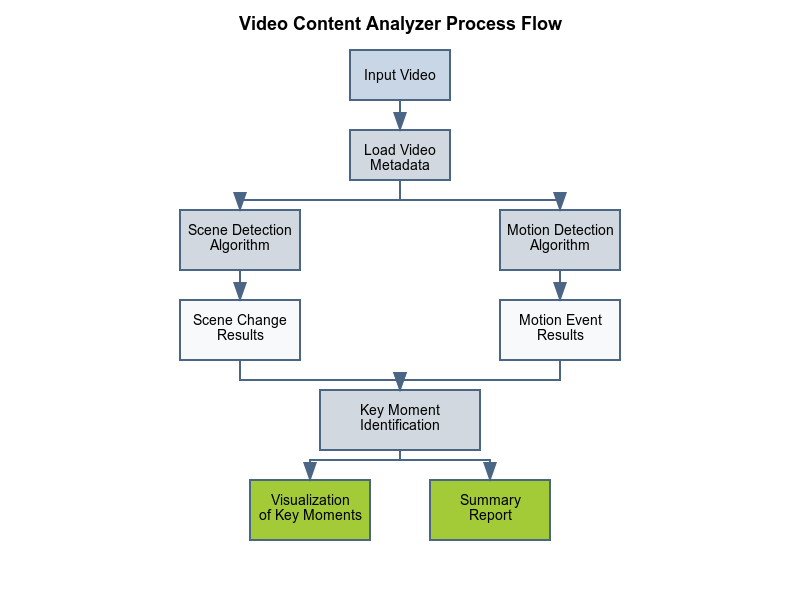

**Skills I'll Develop**


*   Video processing techniques

*   Frame analysis and comparison
*   Scene detection algorithms


*   Understanding temporal data

*   Feature extraction from video











**Set Up the Environment**

In [1]:
# Install required libraries
!pip install opencv-python
!pip install moviepy
!pip install scikit-image
!pip install matplotlib
!apt-get update && apt-get install -y ffmpeg libsm6 libxext6

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,205 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,893 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/univer

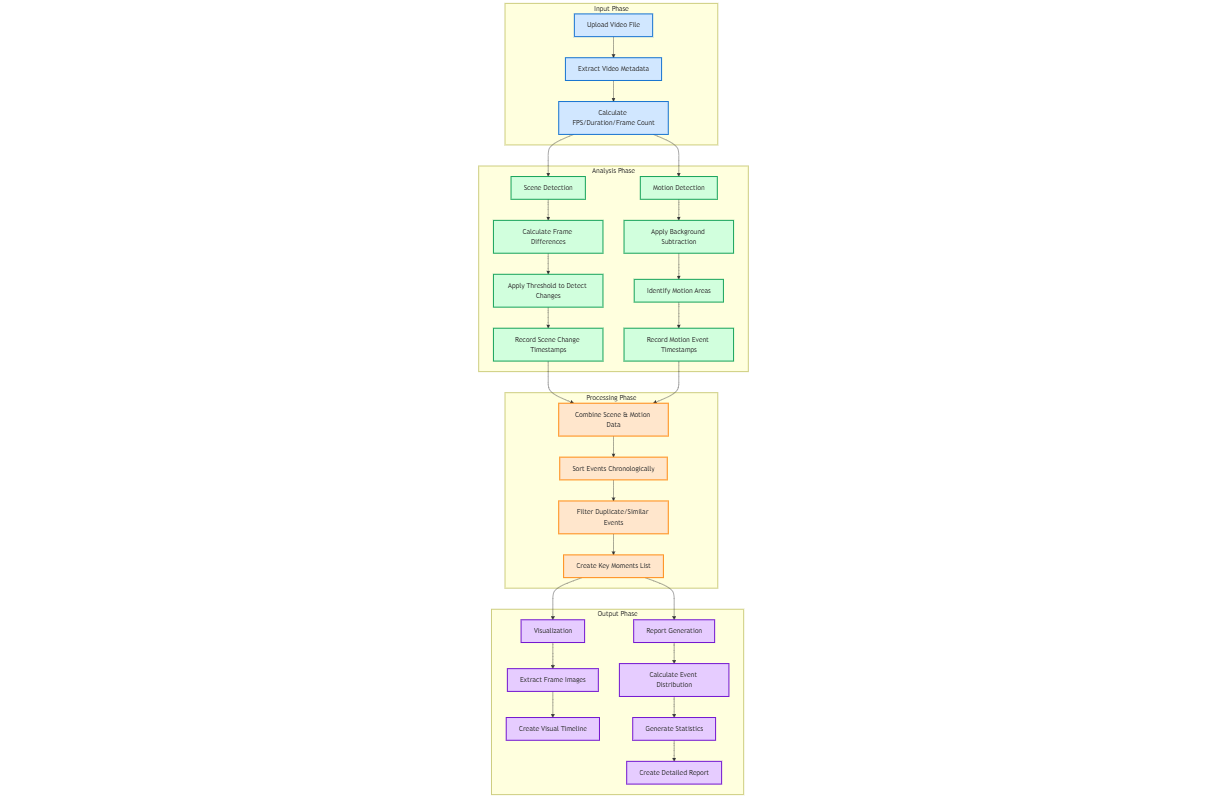

**Load and Process a Video**

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import HTML
from base64 import b64encode

# Upload a video file
uploaded = files.upload()
video_file = next(iter(uploaded))

# Open the video file
video = cv2.VideoCapture(video_file)

# Get basic video information
fps = video.get(cv2.CAP_PROP_FPS)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count / fps

print(f"Video: {video_file}")
print(f"FPS: {fps}")
print(f"Frame Count: {frame_count}")
print(f"Duration: {duration:.2f} seconds")

Saving 1093662-hd_1920_1080_30fps.mp4 to 1093662-hd_1920_1080_30fps.mp4
Video: 1093662-hd_1920_1080_30fps.mp4
FPS: 30.0
Frame Count: 240
Duration: 8.00 seconds


**Implement Scene Detection**

In [5]:
def detect_scenes(video_path, threshold=30.0):
    # Open the video
    video = cv2.VideoCapture(video_path)

    # Read the first frame
    success, prev_frame = video.read()
    if not success:
        return []

    # Convert to grayscale
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    scenes = []
    frame_number = 0

    while True:
        # Read the next frame
        success, curr_frame = video.read()
        frame_number += 1

        if not success:
            break

        # Convert to grayscale
        curr_frame_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

        # Calculate difference between frames
        diff = cv2.absdiff(prev_frame_gray, curr_frame_gray)

        # Calculate the mean difference
        mean_diff = np.mean(diff)

        # If the difference is greater than the threshold, we have a new scene
        if mean_diff > threshold:
            timestamp = frame_number / fps
            scenes.append({
                'frame': frame_number,
                'timestamp': timestamp,
                'diff_score': mean_diff
            })

            # Save a snapshot of this scene change
            # (We'll store the frame for visualization later)
            scenes[-1]['frame_image'] = curr_frame.copy()

        # Update the previous frame
        prev_frame_gray = curr_frame_gray

    video.release()
    return scenes

# Detect scenes
scenes = detect_scenes(video_file)

print(f"Detected {len(scenes)} scene changes")

Detected 0 scene changes


**Implement Motion Detection**

In [6]:
def detect_motion(video_path, min_area=500):
    video = cv2.VideoCapture(video_path)

    # Initialize background subtractor
    back_sub = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=50, detectShadows=True)

    motion_events = []
    frame_number = 0

    while True:
        success, frame = video.read()
        frame_number += 1

        if not success:
            break

        # Apply background subtraction
        fg_mask = back_sub.apply(frame)

        # Apply threshold to eliminate noise
        _, thresh = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours by area
        significant_motion = False
        for contour in contours:
            if cv2.contourArea(contour) > min_area:
                significant_motion = True
                break

        if significant_motion:
            timestamp = frame_number / fps

            # Check if we should merge with a previous motion event
            if motion_events and frame_number - motion_events[-1]['end_frame'] < 10:
                # Extend the previous event
                motion_events[-1]['end_frame'] = frame_number
                motion_events[-1]['end_timestamp'] = timestamp
            else:
                # Create a new motion event
                motion_events.append({
                    'start_frame': frame_number,
                    'end_frame': frame_number,
                    'start_timestamp': timestamp,
                    'end_timestamp': timestamp,
                    'frame_image': frame.copy()
                })

    video.release()

    # Consolidate motion events (merge those that are close together)
    consolidated_events = []
    for event in motion_events:
        if event['end_frame'] - event['start_frame'] > 5:  # Only include events with sufficient duration
            consolidated_events.append(event)

    return consolidated_events

# Detect motion
motion_events = detect_motion(video_file)

print(f"Detected {len(motion_events)} significant motion events")

Detected 1 significant motion events


**Identify Key Moments**

In [7]:
def identify_key_moments(scenes, motion_events, frame_count, fps):
    key_moments = []

    # Add scene changes as key moments
    for scene in scenes:
        key_moments.append({
            'timestamp': scene['timestamp'],
            'frame': scene['frame'],
            'type': 'Scene Change',
            'description': f"New scene detected with difference score of {scene['diff_score']:.2f}",
            'frame_image': scene['frame_image']
        })

    # Add significant motion events as key moments
    for event in motion_events:
        duration = event['end_timestamp'] - event['start_timestamp']
        if duration > 1.0:  # Only include motion events longer than 1 second
            key_moments.append({
                'timestamp': event['start_timestamp'],
                'frame': event['start_frame'],
                'type': 'Motion Event',
                'description': f"Significant motion detected for {duration:.2f} seconds",
                'frame_image': event['frame_image']
            })

    # Sort key moments by timestamp
    key_moments.sort(key=lambda x: x['timestamp'])

    # Identify start and end of video
    key_moments.insert(0, {
        'timestamp': 0.0,
        'frame': 0,
        'type': 'Video Start',
        'description': 'Beginning of the video',
        'frame_image': None  # We'll need to capture this separately
    })

    key_moments.append({
        'timestamp': frame_count / fps,
        'frame': frame_count,
        'type': 'Video End',
        'description': 'End of the video',
        'frame_image': None  # We'll need to capture this separately
    })

    return key_moments

# Identify key moments
key_moments = identify_key_moments(scenes, motion_events, frame_count, fps)

print(f"Identified {len(key_moments)} key moments in the video")

Identified 3 key moments in the video


**Visualize the Results**

In [54]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import pandas as pd

def visualize_key_moments(key_moments, video_path):
    # Limit number of moments to display
    n_moments = min(len(key_moments), 8)

    # Handle case when there are no key moments
    if n_moments == 0:
        print("No key moments to display.")
        return

    # Create subplots
    fig_rows = (n_moments + 1) // 2  # ceil(n_moments / 2)
    fig, axes = plt.subplots(fig_rows, 2, figsize=(12, 3 * fig_rows))
    axes = axes.flatten() if n_moments > 1 else [axes]

    # Load video and patch missing frame images
    video = cv2.VideoCapture(video_path)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    for i, moment in enumerate(key_moments[:n_moments]):
        if moment['frame_image'] is None and 'frame' in moment:
            # Seek to the frame index if known
            video.set(cv2.CAP_PROP_POS_FRAMES, moment['frame'])
            ret, frame = video.read()
            if ret:
                moment['frame_image'] = frame

    video.release()

    # Display each key moment
    for i, moment in enumerate(key_moments[:n_moments]):
        print(f"Moment {i}: has image? {'Yes' if moment['frame_image'] is not None else 'No'}")
        if moment['frame_image'] is not None:
            rgb_frame = cv2.cvtColor(moment['frame_image'], cv2.COLOR_BGR2RGB)
            axes[i].imshow(rgb_frame)
            axes[i].set_title(f"{moment['type']} at {moment['timestamp']:.2f}s")
            axes[i].axis('off')
        else:
            axes[i].set_title("No image available")
            axes[i].axis('off')

    # Hide any unused axes
    for j in range(n_moments, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Display key moment table
    df = pd.DataFrame([
        {
            'Time (s)': f"{m['timestamp']:.2f}",
            'Frame': m.get('frame', 'N/A'),
            'Type': m['type'],
            'Description': m['description']
        } for m in key_moments
    ])

    display(HTML(df.to_html(index=False)))


Moment 0: has image? Yes
Moment 1: has image? Yes
Moment 2: has image? Yes


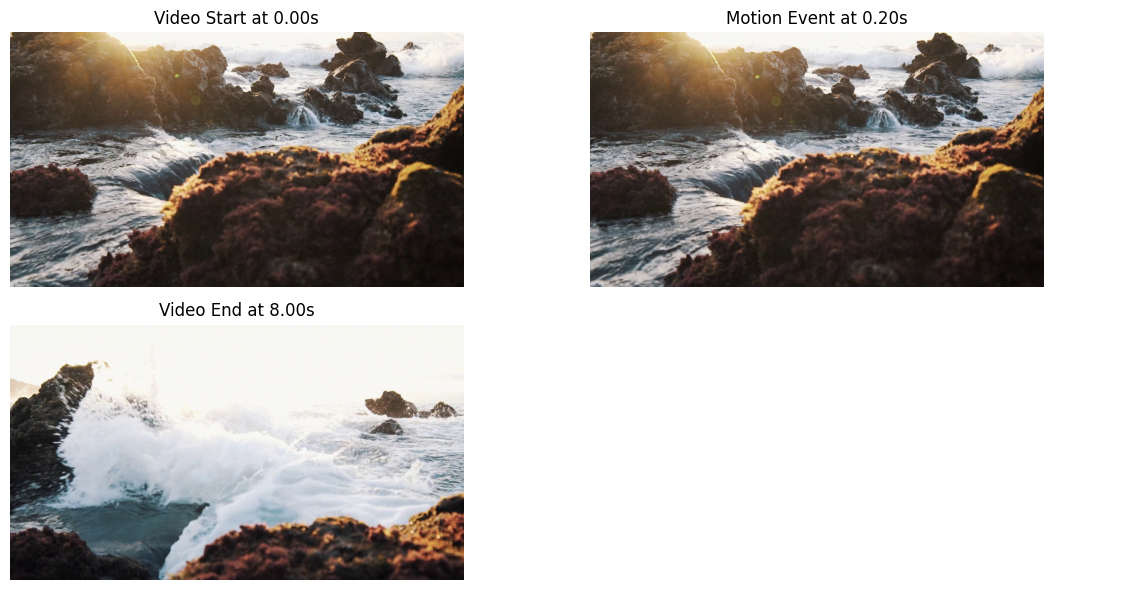

Time (s),Frame,Type,Description
0.00,0,Video Start,Beginning of the video
0.20,6,Motion Event,Significant motion detected for 7.80 seconds
8.00,240,Video End,End of the video


In [55]:
visualize_key_moments(key_moments, video_file)


**Create a Summary Report**

In [45]:
def generate_summary_report(video_file, key_moments, fps, frame_count, duration):
    # Calculate the distribution of key moment types
    types = {}
    for moment in key_moments:
        if moment['type'] not in types:
            types[moment['type']] = 0
        types[moment['type']] += 1

    # Calculate average time between key moments
    timestamps = [moment['timestamp'] for moment in key_moments]
    if len(timestamps) > 1:
        time_diffs = [timestamps[i+1] - timestamps[i] for i in range(len(timestamps)-1)]
        avg_time_between = sum(time_diffs) / len(time_diffs)
    else:
        avg_time_between = 0

    # Generate the report
    report = f"""
    # Video Content Analysis Summary

    ## Video Information
    - Filename: {video_file}
    - Duration: {duration:.2f} seconds
    - Frame Rate: {fps:.2f} FPS
    - Total Frames: {frame_count}

    ## Key Moments Analysis
    - Total Key Moments Detected: {len(key_moments)}
    - Average Time Between Key Moments: {avg_time_between:.2f} seconds

    ## Key Moment Distribution
    """

    for moment_type, count in types.items():
        report += f"- {moment_type}: {count} occurrences\n"

    report += """
    ## Detailed Timeline
    """

    for moment in key_moments:
        report += f"- [{moment['timestamp']:.2f}s] {moment['type']}: {moment['description']}\n"

    return report

# Generate the summary report
summary_report = generate_summary_report(video_file, key_moments, fps, frame_count, duration)
print(summary_report)


    # Video Content Analysis Summary
    
    ## Video Information
    - Filename: 1093662-hd_1920_1080_30fps.mp4
    - Duration: 8.00 seconds
    - Frame Rate: 30.00 FPS
    - Total Frames: 240
    
    ## Key Moments Analysis
    - Total Key Moments Detected: 3
    - Average Time Between Key Moments: 4.00 seconds
    
    ## Key Moment Distribution
    - Video Start: 1 occurrences
- Motion Event: 1 occurrences
- Video End: 1 occurrences

    ## Detailed Timeline
    - [0.00s] Video Start: Beginning of the video
- [0.20s] Motion Event: Significant motion detected for 7.80 seconds
- [8.00s] Video End: End of the video



**Save Results and Create a LinkedIn Post**

In [46]:
# Save the summary report to a file
with open('video_analysis_report.md', 'w') as f:
    f.write(summary_report)

# Download the report file
files.download('video_analysis_report.md')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>